## Goal

Build a router architecture that routes the information based on the llm output.
- Use a prebuilt `ToolNode` and pass in the list of tools.
- Use `tools_condition` edge to route the llm's output.

In [1]:
# general imports
import sys
import os, getpass
from openai import OpenAI
from utils import *
from IPython.display import Image
from pprint import pprint

# Import langgraph modules to create and visualize the graph
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage 
from typing_extensions import TypedDict
from typing import Literal
from pydantic import BaseModel, Field

# Install the missing package
# %pip install langchain_anthropic
# %pip install langchain_groq
from langchain_groq import ChatGroq

In [2]:
# Let's make sure we have the API key set
GROQ_API_KEY = set_api_key('GROQ_API_KEY')

API key found in .env file for GROQ_API_KEY


#### Messages

Chat models can use `messages`, which captures different roles within a conversation (e.g., "system", "human", "assistant").
Messages also feature one or more content blocks that contain text or potentially multimodal data (e.g., images, audio, video).

<h5>Let's create a list of messages. Each message can be supplied with a few things:</h5>

- `content` - content of the message
- `name` - optionally, who is creating the message
-  `response_metadata` - optionally, a dict of metadata that is oftern specific to each model provider

In [3]:

messages = [AIMessage(content=f'So you wanted to know more starwars conception idea?', name = 'AI')]
messages.extend([HumanMessage(content=f'Yes, I am interested in starwars', name = 'Human')])
messages.extend([AIMessage(content=f'What do you want to know about starwars?', name = 'AI')])
messages.extend([HumanMessage(content=f'What is the starwars universe?', name = 'Human')])


In [4]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: AI

So you wanted to know more starwars conception idea?
================================ Human Message =================================
Name: Human

Yes, I am interested in starwars
================================== Ai Message ==================================
Name: AI

What do you want to know about starwars?
================================ Human Message =================================
Name: Human

What is the starwars universe?


### Chat Models

Chat models use a sequence of message as input and support message roles.

There are many chat models available out there to choose from, in our case, we will use Groq.

We can load the AI model and invoke it with our list of messages.


In [5]:
ai = ChatGroq(model="llama-3.3-70b-versatile", api_key=GROQ_API_KEY, temperature=0.8, max_retries=2)

In [6]:
result = ai.invoke(messages)
result.pretty_print()

================================== Ai Message ==================================

The Star Wars universe, also known as the Star Wars galaxy, is a vast, fictional universe created by George Lucas. It's a sprawling, epic space opera that spans thousands of years, numerous planets, and a wide range of characters, species, and technologies.

The Star Wars universe is set in a distant galaxy, where various star systems, planets, and civilizations coexist. The galaxy is divided into different regions, including:

1. **The Core Worlds**: The central, densely populated region of the galaxy, home to powerful, advanced civilizations.
2. **The Inner Rim**: A transitional region between the Core Worlds and the Outer Rim, characterized by a mix of urban and rural areas.
3. **The Outer Rim**: A vast, less-developed region, home to many independent systems, smugglers, and lawless planets.
4. **The Unknown Regions**: Uncharted, mysterious areas of the galaxy, often shrouded in myth and legend.

The S

In [7]:
result.response_metadata

{'token_usage': {'completion_tokens': 568,
  'prompt_tokens': 90,
  'total_tokens': 658,
  'completion_time': 2.065454545,
  'prompt_time': 0.006626076,
  'queue_time': 0.23509706,
  'total_time': 2.072080621},
 'model_name': 'llama-3.3-70b-versatile',
 'system_fingerprint': 'fp_7b42aeb9fa',
 'finish_reason': 'stop',
 'logprobs': None}

In [8]:
stream = ai.stream(messages)
full = next(stream)
for chunk in stream:
    full += chunk
full.pretty_print()

============================ Aimessagechunk Message ============================

The Star Wars universe, also known as the Star Wars galaxy, is a vast, fictional universe created by George Lucas. It's a sprawling, epic space fantasy that encompasses numerous planets, star systems, alien species, and technologies. The universe is divided into several distinct eras, including:

1. **The Old Republic Era**: Thousands of years before the main events of the Star Wars saga, this era is marked by the rise and fall of ancient civilizations, such as the Sith and Jedi Orders.
2. **The High Republic Era**: A period of peace and prosperity, where the Jedi and the Galactic Republic work together to maintain balance and order in the galaxy.
3. **The Fall of the Jedi Era**: A time of great turmoil, marked by the rise of the evil Empire and the near-destruction of the Jedi Order.
4. **The Rebellion Era**: The period of the original Star Wars trilogy (Episodes IV-VI), where the Rebel Alliance fights a

<h4> Tools </h4>

Tools are an additional capability provided to LLMs that can be used to interact with outside world.

It could be leveraged to control different parts of the code, call an external API, interact with database, trigger a lambda function, etc.

Tools can be as simple as Python functions or as complex as integrating LLM with RAG for real time analysis.

In [49]:
class GetExponent(BaseModel):
    """
    Raise x to the power of y.
    
    Args:
    x (int): The base number.
    y (int): The exponent number.
    result (int): Multiply x by itself y times.
    """
    x: int = Field(description='The base number')
    y: int = Field(description='The exponent number')
    result: int = Field(description='Multiply x by itself y times')
    

In [50]:
ai_with_tool = ai.bind_tools([GetExponent])

In [63]:
tool_call = ai_with_tool.invoke([HumanMessage(content='You are a calculator assistant with all the tools required to perfom mathematical operations. \
                                              What is 10 raised to the power of 3')])

In [64]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yjhq', 'function': {'arguments': '{"x": 10, "y": 3, "result": 0}', 'name': 'GetExponent'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 342, 'total_tokens': 369, 'completion_time': 0.098181818, 'prompt_time': 0.021900658, 'queue_time': 0.23039053700000003, 'total_time': 0.120082476}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ca0059abb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6c37ddb3-13de-45f7-982d-dbbcab0d0621-0', tool_calls=[{'name': 'GetExponent', 'args': {'x': 10, 'y': 3, 'result': 0}, 'id': 'call_yjhq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 342, 'output_tokens': 27, 'total_tokens': 369})

<h5>ToolNode</h5>

It is basically a LangChain Runnable that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls. 

The state must have `messages` channel with an appropriate reducer for ToolNode to work.

There are two ways to call `ToolNode` i.e Either manually using an AIMessage or use a ChatModel with bind tools to call ToolNode

In [14]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [15]:
# Let's define an initial state with an initial message
initial_messages= [AIMessage(content='Hello, I am a calculator assistant. I can help you with mathematical operations.', name='AI'),
                   HumanMessage(content='I am looking for information on how to perform exponentiation', name='Human')]

# New message to add
new_message = AIMessage(content='I can help you with that. What is the base number and the exponent number?', name='AI')

# test 
add_messages(initial_messages, new_message)

[AIMessage(content='Hello, I am a calculator assistant. I can help you with mathematical operations.', additional_kwargs={}, response_metadata={}, name='AI', id='14c4431c-1a64-42a2-92ec-ec95bfabbbe1'),
 HumanMessage(content='I am looking for information on how to perform exponentiation', additional_kwargs={}, response_metadata={}, name='Human', id='d62090e5-e802-4d0e-bfd6-a8e4d6cc3392'),
 AIMessage(content='I can help you with that. What is the base number and the exponent number?', additional_kwargs={}, response_metadata={}, name='AI', id='68eae680-ebb7-4458-bce6-7d133433f05f')]

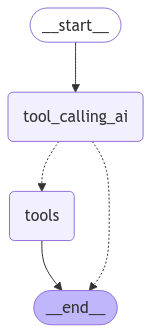

In [21]:
# Since this message update is so common, Langgraph has prebuilt MessagesState
from langgraph.graph import MessagesState # MessagesState and State work equivalently
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
# Let's build our graph

class MessagesState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages] # we need to add this line to the class to make it a Pydantic model

# node function
def model_with_tools(state: MessagesState):
    return {"messages": [ai_with_tool.invoke(state["messages"])]} # invoke the tool_calling_ai tool

# build graph
builder = StateGraph(MessagesState)
builder.add_node('tool_calling_ai', model_with_tools)
builder.add_node('tools', ToolNode([GetExponent]))
builder.add_edge(START, 'tool_calling_ai')
builder.add_conditional_edges('tool_calling_ai', tools_condition)
builder.add_edge('tools', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [140]:
message_invoke = graph.invoke({"messages" : HumanMessage(content='Hello!')} )
message_invoke

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='dce5fdf9-48dc-4e29-9dfc-da2b4d0d3e08'),
  AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 328, 'total_tokens': 354, 'completion_time': 0.094545455, 'prompt_time': 0.014779952, 'queue_time': 0.233694885, 'total_time': 0.109325407}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_5f849c5a0b', 'finish_reason': 'stop', 'logprobs': None}, id='run-27162e41-c2ba-44c8-bf3d-1f3faf13fc4d-0', usage_metadata={'input_tokens': 328, 'output_tokens': 26, 'total_tokens': 354})]}

In [145]:
message_invoke = graph.invoke({"messages" : HumanMessage(content='You are a calculator assistant with all the tools required to perfom mathematical operations. What is 2 raised to the power of 3')} )
message_invoke

{'messages': [HumanMessage(content='You are a calculator assistant with all the tools required to perfom mathematical operations. What is 2 raised to the power of 3', additional_kwargs={}, response_metadata={}, id='3ba20a56-cf63-4b8d-8956-82f82d69e4c4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q3tb', 'function': {'arguments': '{"x": 2, "y": 3, "result": 8}', 'name': 'GetExponent'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 353, 'total_tokens': 380, 'completion_time': 0.098181818, 'prompt_time': 0.016811323, 'queue_time': 0.232832494, 'total_time': 0.114993141}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_7b42aeb9fa', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-669cdad9-af27-49f8-9c16-c81649eb0170-0', tool_calls=[{'name': 'GetExponent', 'args': {'x': 2, 'y': 3, 'result': 8}, 'id': 'call_q3tb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 353, 'output_to

In [147]:
message_invoke = graph.invoke({"messages" : HumanMessage(content='Are you still there')} )
message_invoke

{'messages': [HumanMessage(content='Are you still there', additional_kwargs={}, response_metadata={}, id='2704558a-e039-4c60-b678-fbe6bbde2b8b'),
  AIMessage(content="I'm here and ready to help. You can ask me a question or request a function call. If you need to raise a number to a power, I can assist you with the 'GetExponent' function.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 330, 'total_tokens': 375, 'completion_time': 0.163636364, 'prompt_time': 0.01712404, 'queue_time': 0.30162517099999997, 'total_time': 0.180760404}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_7b42aeb9fa', 'finish_reason': 'stop', 'logprobs': None}, id='run-7e932600-4648-4853-b894-9d60177fe7e8-0', usage_metadata={'input_tokens': 330, 'output_tokens': 45, 'total_tokens': 375})]}

`We can see above that based on the input invokation, the llm uses either a tool call or gives a direct response. It also updates the messages channel.`  